In [9]:
########################################
#LIBRARIES
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import os
import time

########################################
#PARAMETERS
nTimeSteps = 60 #at 60 Hz
samplenum = 5
hiddenlayers = [100]
input_size = 3
output_size = 3*nTimeSteps
simulation_file_path = '../Data/Simulations/pm_target.sim'
objective_file_path = f'../Data/Objectives/pm_target_{nTimeSteps}.obj'

# set log level
dde.set_log_level(dde.LogLevel.off)

#######################################
# LOAD SIMULATION AND OBJECTIVE FUNCTION
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)

# Objective Function
obj = dde.InverseObjective(dyn)
obj.loadFile(objective_file_path)
objective_json = json.load(open(objective_file_path))
opt = dde.Newton()

##########################################
#SAMPLE TARGETS
y_target = np.zeros((samplenum,3))
y_target[:,2] = np.random.rand(samplenum)
y_target[:,1] = np.random.rand( samplenum)
y_target[:,0] = np.random.rand(samplenum)
print("done")

###################################
#USE P FROM TRAJ_OPT
p = np.ones((3*nTimeSteps, samplenum))
for i in range(samplenum):
    objective_json["objectives"]["pmTargetPositions"][0]["targetPos"] = ([[y_target[i,0]],[y_target[i,1]],[y_target[i,2]]]) 
    obj.loadJson(objective_json)
    p[:,i] = opt.minimize(obj, p_init)
p = torch.tensor(p, requires_grad = True).t().double()
print(p.shape)

done
torch.Size([5, 180])


In [10]:
##########################################
#BUILD CUSTOM SIMULATION FUNCTION
class Simulate(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        #print(f'input: {input.shape}')
        p = input.clone().numpy().transpose()
        y_pred = torch.ones([len(p[0, :]),3*nTimeSteps])
        for i in range(len(p[0, :])):
            state = dyn.q(p[:,i])
            y_pred[i, :] = torch.tensor(state.q)
        #print(f'y_pred: {y_pred.shape}')
        
        ctx.save_for_backward(input)
        
        return y_pred
        
    @staticmethod
    def backward(ctx, grad_output):
        #print(grad_output)
        input, = ctx.saved_tensors
        p = input.clone().numpy().transpose()
        dq_dp_batch = torch.zeros([3*nTimeSteps, 3*nTimeSteps])
        for i in range(len(p[0, :])):
            state = dyn.q(p[:, i])
            dq_dp = dyn.dq_dp(state, p[:, i])
            dq_dp = torch.tensor(dq_dp)
            dq_dp_batch = dq_dp_batch + dq_dp
        #print(f'dy/dp_batch: {dy_dp_batch/samplenum}')
        
        grad_input = grad_output.mm(dq_dp_batch.float()/len(p[0,:]))
        #print(f'shape of grad input: {grad_input.shape}')
        #print(f'shape of grad output: {grad_output.shape}')
        return grad_input

Simulate = Simulate.apply

In [11]:
################################
#GET ANALYTICAL GRADIENT

# Error for whole simulation
from numpy import linalg as LA

p = torch.tensor(p, requires_grad = True).double()
y = Simulate(p)
grad_output = torch.ones([samplenum,3*nTimeSteps]).double()
y.backward(grad_output)
dy_dp = p.grad.double()
print(f'dy_dp shape = {dy_dp.shape}')
print(f'dy_dp = {dy_dp}')

dy_dp shape = torch.Size([5, 180])
dy_dp = tensor([[ 1.3304e+00, -1.6164e+00,  1.2847e+00,  1.2987e+00, -1.7246e+00,
          1.2510e+00,  1.2686e+00, -1.7989e+00,  1.2185e+00,  1.2416e+00,
         -1.8413e+00,  1.1890e+00,  1.2194e+00, -1.8538e+00,  1.1642e+00,
          1.2032e+00, -1.8384e+00,  1.1456e+00,  1.1942e+00, -1.7967e+00,
          1.1344e+00,  1.1933e+00, -1.7301e+00,  1.1317e+00,  1.2012e+00,
         -1.6397e+00,  1.1385e+00,  1.2185e+00, -1.5261e+00,  1.1552e+00,
          1.2454e+00, -1.3896e+00,  1.1824e+00,  1.2819e+00, -1.2304e+00,
          1.2202e+00,  1.3279e+00, -1.0484e+00,  1.2684e+00,  1.3827e+00,
         -8.4371e-01,  1.3268e+00,  1.4457e+00, -6.1642e-01,  1.3944e+00,
          1.5155e+00, -3.6711e-01,  1.4702e+00,  1.5906e+00, -9.6860e-02,
          1.5526e+00,  1.6692e+00,  1.9249e-01,  1.6396e+00,  1.7488e+00,
          4.9821e-01,  1.7288e+00,  1.8269e+00,  8.1654e-01,  1.8173e+00,
          1.9004e+00,  1.1426e+00,  1.9020e+00,  1.9663e+00,  1.4704e

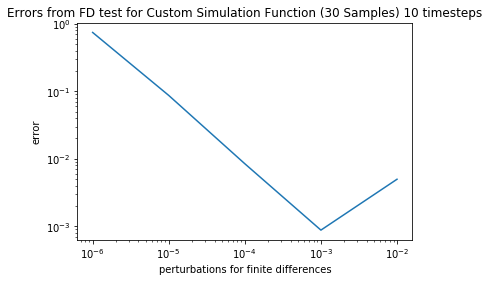

In [12]:
################################
#GET NUMERICAL GRADIENT WITH DIFFERENT PERTUBATIONS

dy_dp_s = np.zeros((len(p_init),len(p_init)))
#dy_dp_FD = np.zeros((3,len(dyn.p_init)))
#FD = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
FD = np.logspace(np.log10(0.000001),np.log10(0.01),num = 5)
Grads = {}
Err = []
analytical_grad = dy_dp.detach().numpy()

for f, fd in enumerate(FD):
    dy_dp_FD = np.zeros((len(p_init),len(p_init)))
    for s in range(samplenum):
        for i in range(len(p_init)):
            dp= np.zeros(len(p_init))
            dp[i] = fd
            dp = torch.tensor(dp)
            p_s = p[s,:]
            p_s = p_s.unsqueeze(0)
            y_p = Simulate(p_s + dp)
            y_m = Simulate(p_s - dp)
            y_p = y_p.detach().numpy()
            y_m = y_m.detach().numpy()
            grad_i = (y_p - y_m) / (2 * fd)
            dy_dp_s[:, i]= grad_i
        dy_dp_FD = dy_dp_FD + dy_dp_s
    dy_dp_FD_ten = torch.tensor(dy_dp_FD)
    Grads[fd] = torch.tensor(grad_output.double().mm(dy_dp_FD_ten/samplenum))
    #print(f' dy_dp_FD at eps {fd} = \n{dy_dp_FD}')
    Err.append(LA.norm(Grads[fd] - analytical_grad))
    
################################
#PLOT ERRORS OVER DIFFERENT PERTURBATIONS

plt.plot(FD, Err)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('perturbations for finite differences')
plt.title('Errors from FD test for Custom Simulation Function (30 Samples) 10 timesteps')
plt.show()

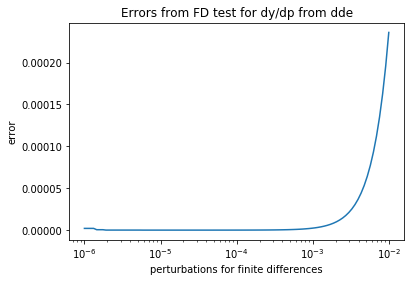

In [134]:
################################
#FD TEST FOR DY/DP FUNCTION

from numpy import linalg as LA
#FD = [1e-2, 1e-3, 1e-4, 1e-5]
#FD = np.linspace(0.000001,0.01, num = 100)
FD = np.logspace(np.log10(0.000001),np.log10(0.01),num = 100)
FDs = []

#Calculate dy_dp with FE
dy_dp = dyn.dy_dp(state_init, dyn.p_init)[-3:, :]
dy_dp_FD = np.zeros((3,len(dyn.p_init)))

for i, fd in enumerate(FD):
    for i in range(len(dyn.p_init)):
        dp= np.zeros(len(dyn.p_init))
        dp[i] = fd
        y_p = dyn.compute(dyn.p_init + dp)
        y_m = dyn.compute(dyn.p_init - dp)
        dy_dp_FD[:, i] = (y_p.y[-3:] - y_m.y[-3:]) / (2* fd)
    err = LA.norm(dy_dp_FD - dy_dp)
    #print(err)
    FDs.append(err)

plt.plot(FD, FDs)
plt.xscale('log')
plt.ylabel('error')
plt.title('Errors from FD test for dy/dp from dde')
plt.xlabel('perturbations for finite differences')
plt.show()